### Import basic libraries and load data
We will import the basic libraries that we use in every single Data Science project, these are pandas, numpy and matplotlib.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Next, we load the data. We will use the same dataset as in the previous articles to be able to make a comparison. This is a dataset with Forex data with 3 years of records starting from 2018. This data includes six different currency prices with respect to the US Dollar (USD). These are also called Forex (Foreign Exchange) pairs. For this example we will focus on the Euro to Dollar pair.

Let's load the data and inspect it:

In [3]:
df = pd.read_csv('/kaggle/input/forex-data/data.csv')
df

,Date,EUR/USD,USD/JPY,GBP/USD,USD/CHF,USD/CAD,AUD/USD
0,2018-01-01,1.2010,112.66,1.3503,0.9745,1.2545,0.7805
1,2018-01-02,1.2059,112.30,1.3588,0.9716,1.2513,0.7830
2,2018-01-03,1.2014,112.50,1.3516,0.9771,1.2533,0.7836
3,2018-01-04,1.2068,112.75,1.3553,0.9746,1.2487,0.7864
4,2018-01-05,1.2030,113.08,1.3571,0.9752,1.2409,0.7864
...,...,...,...,...,...,...,...
779,2020-12-25,1.2204,103.48,1.3548,0.8889,1.2869,0.7599
780,2020-12-28,1.2214,103.78,1.3449,0.8884,1.2845,0.7577
781,2020-12-29,1.2247,103.56,1.3500,0.8843,1.2817,NaN
782,2020-12-30,1.2295,103.17,1.3622,0.8810,1.2758,0.7684


We need to address the missing values and the format of the date.

In [4]:
# Fill missing values
df = df.ffill()

# Convert date to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Set date as the index
df = df.set_index(['Date'])

We want all of the different currencies referenced to US Dollars, that's why we need to apply the inverse if that's not the case:

In [5]:
for pair in df.columns:
    if (pair.split('/')[0] == 'USD') & (pair.split('/')[1] != 'USD'):
        df[f"{pair.split('/')[1]}/{pair.split('/')[0]}"] = 1 / df[pair]
        df = df.drop(columns=[pair])

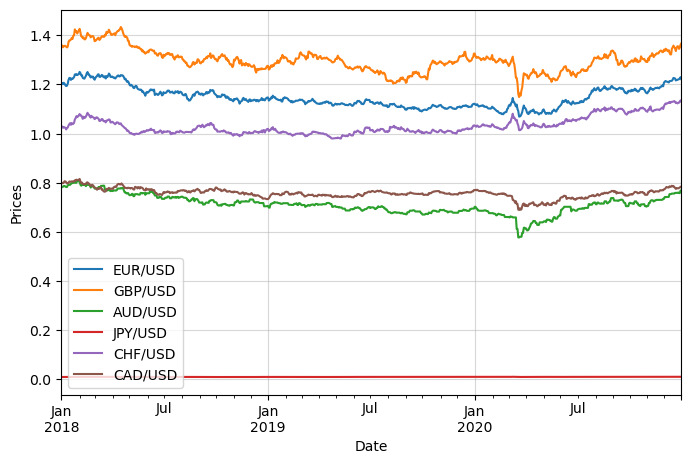

In [6]:
df.plot(figsize=(8,5))
plt.grid(alpha=0.5)
plt.ylabel('Prices')
plt.show()

Let's calculate the log returns to make them stationary and bring them to a similar scale:

### Calculation of Log-Returns

In [7]:
df_logret = np.log(df).diff()
df_logret.dropna(inplace=True)
df_logret

,EUR/USD,GBP/USD,AUD/USD,JPY/USD,CHF/USD,CAD/USD
Date,,,,,,
2018-01-02,0.004072,0.006275,0.003198,0.003201,0.002980,0.002554
2018-01-03,-0.003739,-0.005313,0.000766,-0.001779,-0.005645,-0.001597
2018-01-04,0.004485,0.002734,0.003567,-0.002220,0.002562,0.003677
2018-01-05,-0.003154,0.001327,0.000000,-0.002923,-0.000615,0.006266
2018-01-08,-0.005251,-0.000221,-0.002929,-0.000088,-0.001946,-0.000967
...,...,...,...,...,...,...
2020-12-25,0.001476,-0.000517,0.001844,0.001449,0.001911,0.000311
2020-12-28,0.000819,-0.007334,-0.002899,-0.002895,0.000563,0.001867
2020-12-29,0.002698,0.003785,0.000000,0.002122,0.004626,0.002182


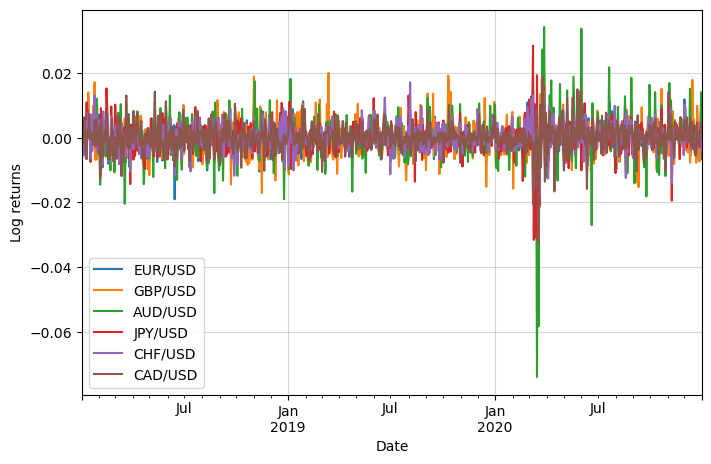

In [8]:
df_logret.plot(figsize=(8,5))
plt.grid(alpha=0.5)
plt.ylabel('Log returns')
plt.show()

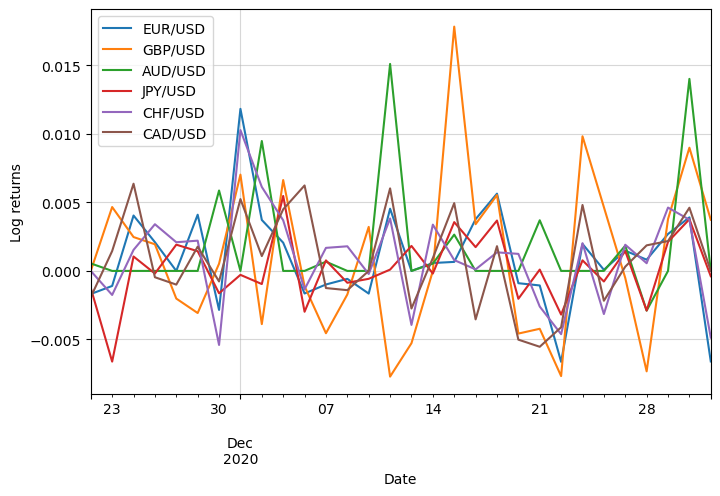

In [9]:
df_logret.iloc[-30:].plot(figsize=(8,5))
plt.grid(alpha=0.5)
plt.ylabel('Log returns')
plt.show()

The next step is to reframe the dataset as a supervised problem.
This time let's work with numpy instead of using pandas. We will focus for now only on the univariate problem, in other words, predicting the EUR/USD return using solely the previous returns. First let's convert our dataframe into a numpy array:

In [11]:
rets = df_logret['EUR/USD'].values

We will use the returns during the previous week (7 days) to predict the next day's return.

In [12]:
# Initialize empty lists
x = []
y = []

timesteps = 7

for i in range(rets.shape[0] - timesteps):
    x.append(rets[i: i + timesteps])
    y.append(rets[i + timesteps])
    
x = np.array(x)
y = np.array(y)

Neural Networks employ a unique input structure that sets them apart from other Machine Learning algorithms. Rather than using pandas dataframes, they necessitate the use of numpy arrays. Specifically, for Recurrent Neural Networks (RNNs), the dimensions of the input and output variables must conform to the following guidelines:

* Independent Variables (X): The input tensor should have a three-dimensional shape, represented as: [number of samples, number of timesteps, number of features].

* Dependent Variable (y): The shape of the output tensor can vary depending on the task at hand. For simpler tasks like classification or regression, it is often a two-dimensional array with dimensions [number of samples, output features].

This ensures that the data is properly formatted for processing within the RNN architecture.

In our case,
* X: [776, 7, 1]
* y: [776, 1]

However, they don't respect this structure:


In [13]:
x.shape, y.shape

((776, 7), (776,))

We need to reshape them:

In [14]:
x = x.reshape(*x.shape,1)
y = y.reshape(-1,1)

We can see that now they are correctly dimensioned:

In [15]:
x.shape, y.shape

((776, 7, 1), (776, 1))

We need to split the data into training and testing set. Let's select 90% of the data for training and a 10% for testing the model performance.

In [16]:
n_train = int(x.shape[0] * 0.9)
n_train

698

### Train the RNN model
First we need to import the required libraries:

In [101]:
import keras
from keras import layers

Let's build the model and compile it. We will use a single vanilla RRN layer. It is important to define the number of units, the input shape and the activation function.

We will use a tanh activation function. The tanh activation function is commonly used in RNNs for the following key reasons:

* Non-linearity: Enables the network to learn complex patterns.
* Output Range: Outputs values between −1 and 1, helping to center the data.
* Vanishing Gradient: Mitigates the vanishing gradient problem to some extent.
* Gradient: Steeper gradient compared to sigmoid, aiding faster learning.

Setting the number of units (also known as neurons or hidden states) in a RNN is more of an art than an exact science, but there are some general guidelines you can follow:

* Experimentation: The most reliable way to determine the optimal number of units is through experimentation. You can use techniques like cross-validation to evaluate different configurations.
* Problem Complexity: For simple tasks, a smaller number of units may be sufficient. For more complex tasks involving long sequences, you may need more units to capture the complexity.
* Computational Resources: More units generally require more computational resources. Make sure your choice aligns with the hardware you have available.
* Overfitting vs. Underfitting: A large number of units may lead to overfitting, especially if you have limited data. Also, too few units may result in underfitting. Regularization techniques can help balance this.
* Architecture: The number of units often depends on the specific RNN architecture you're using. For example, LSTMs and GRUs might require different numbers of units compared to vanilla RNNs.
* Empirical Rules: Some practitioners follow empirical rules, like setting the number of units to be somewhere between the size of the input layer and the size of the output layer.
* Grid Search: Automated hyperparameter tuning methods like grid search or random search can help you find an optimal number of units.

We will set it to 5 to start with. This is something that we could optimize as previously said.

The input shape is the number of timesteps by the number of features, in this case [7, 1].

In [18]:
# Initialize the Sequential model
model = keras.Sequential()

# Add an RNN layer with 5 units and tanh activation
model.add(layers.SimpleRNN(5, activation='tanh', use_bias=True, input_shape=(x.shape[1], x.shape[2])))

We can add a dropout layer. This serves primarily to combat overfitting. Here are the key reasons:

* Regularization: Dropout acts as a form of regularization by randomly setting a fraction of input units to 0 during training, which helps to prevent overfitting.
* Generalization: By deactivating some neurons during training, dropout forces the network to learn more robust features that generalize better to unseen data.
* Simplification: Dropout effectively creates a simpler model during each training iteration, reducing the model's complexity.
* Ensemble Effect: Dropout can be seen as training a collection of sub-networks that share weights, contributing to a sort of ensemble effect, which often results in better performance.

Adding dropout layers is a common practice but should be done carefully to avoid underfitting or extended training times. Typical dropout rates are between 0.2 and 0.5. We will set it to the lowest recommended value: 0.2.

In [19]:
# Add a Dropout layer with a rate of 0.2 to prevent overfitting
model.add(layers.Dropout(rate=0.2))

We could also add a Dense Layer, but this is not necessary. When should we use it?

We could use a Dense Layer if:
* Output Size: You need to transform the RNN output to a single value.
* Complexity: The RNN alone isn't capturing stock price patterns well.
* Fine-tuning: You want extra parameters to improve performance.

We should skip Dense Layer if:
* Simplicity: The RNN is already effective.
* Overfitting: You have a small or noisy dataset.
* Computational Cost: You want to minimize training time.

Let's include it just to make a more general model:

In [20]:
# Add a Dense layer with 1 unit for the output (useful for regression tasks)
model.add(layers.Dense(1))

Time to compile the model. We will use the MSE loss and the Adam optimizer:

In [21]:
# Compile the model with mean squared error loss function and adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

Let's see the architecture of our model:

In [22]:
# Display the architecture of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 5)                 35        
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


Time to train it. We will use only the first 90% of our data, corresponding to our training set. 
Since this is a Time Series problem, we must not shuffle the data. 
We will set the validation split to 20%, this reserves that percentage of the training data for validation purposes. The model will set this fraction of the training data aside and not use it for training. It will evaluate the validation loss and any validation metrics on this data at the end of each epoch.

In [23]:
# Fitting the data
history = model.fit(x[:n_train],
                    y[:n_train],
                    shuffle = False,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/100
18/18 [==============================] - 2s 23ms/step - loss: 1.0273e-04 - val_loss: 1.2418e-04
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 7.6808e-05 - val_loss: 9.0449e-05
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 5.5346e-05 - val_loss: 7.1255e-05
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 4.9279e-05 - val_loss: 5.9443e-05
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 3.7896e-05 - val_loss: 5.1201e-05
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 3.6835e-05 - val_loss: 4.5716e-05
Epoch 7/100
18/18 [==============================] - 0s 5ms/step - loss: 2.8633e-05 - val_loss: 4.2689e-05
Epoch 8/100
18/18 [==============================] - 0s 5ms/step - loss: 2.8387e-05 - val_loss: 4.0738e-05
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 2.9024e-05 - val_loss: 4.0653e-05
Epoch 10/100
18/18 [================

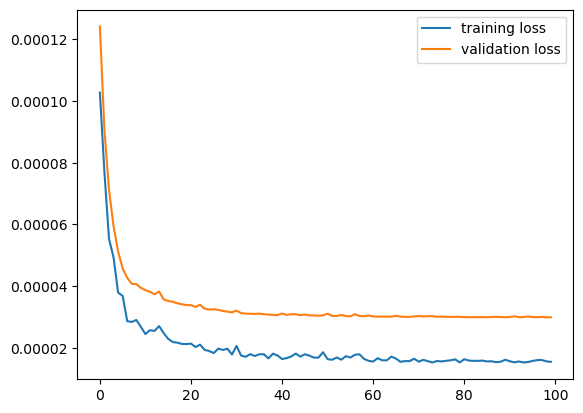

In [24]:
# Plotting the loss iteration
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label ='validation loss')
plt.legend()
plt.show()

Let's make the predictions and the evaluation

In [25]:
y_true = y[n_train:]
y_pred = model.predict(x[n_train:])

3/3 [==============================] - 0s 3ms/step


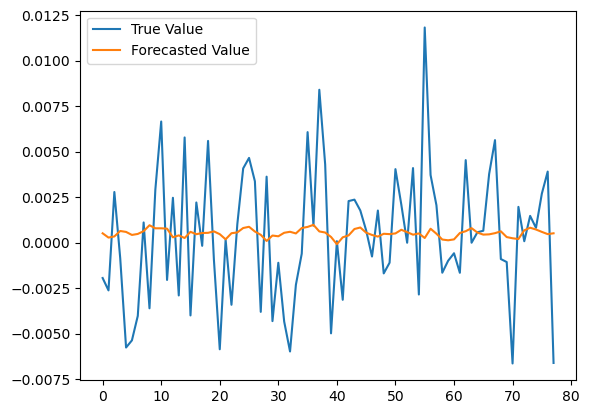

In [26]:
plt.plot(y_true, label = 'True Value')
plt.plot(y_pred, label = 'Forecasted Value')
plt.legend()

In [27]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_true, y_pred))

0.0036406275418344263

We can see that the model is not good enough in predicting the returns. We need more data and more features to improve it. We can add the other currency pairs to see if there is an improvement.

In [28]:
rets_multi = df_logret.values

In [29]:
rets_multi.shape

(783, 6)

We will use the returns during the previous week of the six currency pairs to predict the next day's return of the EUR/USD pair.

In [30]:
# Initialize empty lists
x_multi = []
y_multi = []

timesteps = 7

for i in range(rets_multi.shape[0] - timesteps):
    x_multi.append(rets_multi[i: i + timesteps])
    y_multi.append(rets_multi[i + timesteps][0])
    
x_multi = np.array(x_multi)
y_multi = np.array(y_multi)

In [31]:
x_multi.shape, y_multi.shape

((776, 7, 6), (776,))

In [32]:
# Initialize the Sequential model
model = keras.Sequential()

# Add an RNN layer with 5 units and tanh activation
model.add(layers.SimpleRNN(5, activation='tanh', use_bias=True, input_shape=(x_multi.shape[1], x_multi.shape[2])))

# Add a Dropout layer with a rate of 0.2 to prevent overfitting
model.add(layers.Dropout(rate=0.2))

# Add a Dense layer with 1 unit for the output
model.add(layers.Dense(1))

# Compile the model with mean squared error loss function and adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

# Display the architecture of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 5)                 60        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 66
Trainable params: 66
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Fitting the data
history = model.fit(x_multi[:n_train],
                    y_multi[:n_train],
                    shuffle = False,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/100
18/18 [==============================] - 1s 21ms/step - loss: 2.2153e-04 - val_loss: 3.4512e-04
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 1.6288e-04 - val_loss: 2.7378e-04
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 1.3914e-04 - val_loss: 2.2743e-04
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 1.1211e-04 - val_loss: 1.9483e-04
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 8.5921e-05 - val_loss: 1.7334e-04
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 7.8463e-05 - val_loss: 1.5569e-04
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 7.1984e-05 - val_loss: 1.4156e-04
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 6.5359e-05 - val_loss: 1.3037e-04
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 5.6711e-05 - val_loss: 1.1915e-04
Epoch 10/100
18/18 [================

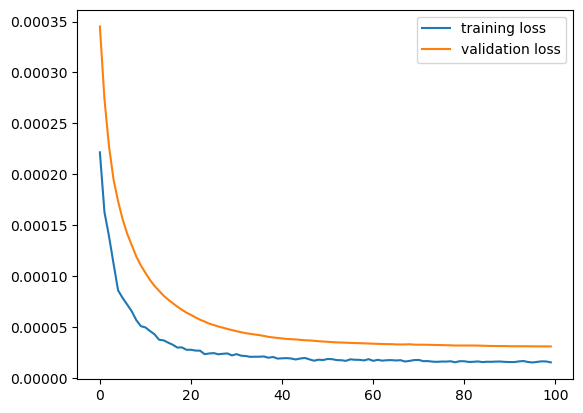

In [34]:
# Plotting the loss iteration
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label ='validation loss')
plt.legend()

In [35]:
y_multi_true = y_multi[n_train:]
y_multi_pred = model.predict(x_multi[n_train:])

3/3 [==============================] - 0s 4ms/step


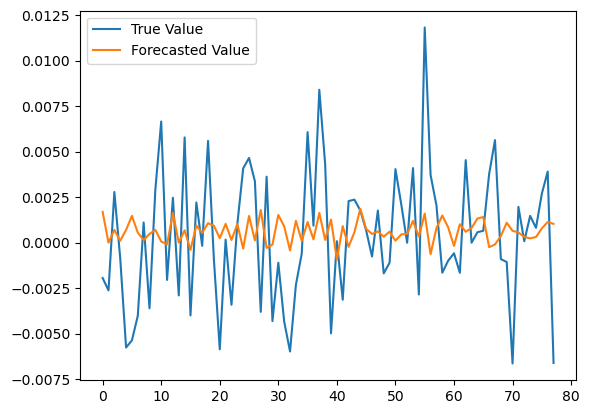

In [36]:
plt.plot(y_multi_true, label = 'True Value')
plt.plot(y_multi_pred, label = 'Forecasted Value')
plt.legend()

In [37]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_multi_true, y_multi_pred))

0.0036843438681295596

In [ ]:
y_multi_true = y_multi[n_train]
y_multi_pred = model.predict(x_multi[n_train:])

Get the prices and compare uni with multivariate forecasts:

In [93]:
import datetime

# Get previous day's price
prices_yesterday = df.iloc[n_train+timesteps: ,0].shift(1).dropna()

# Univariate forecasted prices
y_pred_prices = prices_yesterday * np.exp(y_pred.flatten())
                                          
# Multivariate forecasted prices
y_multi_pred_prices = prices_yesterday * np.exp(y_multi_pred.flatten())

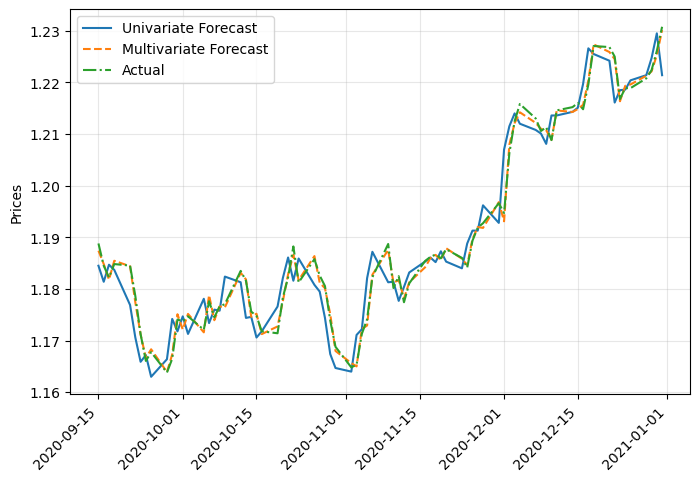

In [100]:
plt.figure(figsize=(8,5))
plt.plot(df.iloc[n_train+timesteps+1:,0])
plt.plot(y_pred_prices, '--')
plt.plot(y_multi_pred_prices, '-.')
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3)
plt.ylabel('Prices')
plt.legend(['Univariate Forecast', 'Multivariate Forecast', 'Actual'])
plt.show()